Modified from: https://towardsdatascience.com/getting-started-with-gans-using-pytorch-78e7c22a14a5

I modify the input image from 64x64x3 to 128x128x3.
Also modify the loss function from GAN to WGAN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torch.utils.data as Data
import matplotlib.pyplot as plt
import os
import cv2

In [ ]:
if(torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device= torch.device("cpu")
  print(device)

cuda Tesla T4


Connect to Google drive to generate data loader. 

If you train using your own PC with Anaconda
1. do not run drive.mount ("/content/gdrive", force_remount=True)
2. train_dataset = datasets.ImageFolder(root = "C:/Users/ADMIN/Google 雲端硬碟/Image folders/train", transform = transformer) 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
image_size = 128 
batch_size = 128

In [ ]:
transformer = transforms.Compose([
  transforms.Resize((image_size, image_size)),       
  transforms.ToTensor(),                     
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] )])

In [ ]:
train_dataset = datasets.ImageFolder(root = "/content/gdrive/MyDrive/Image folders/train", transform = transformer)

In [ ]:
train_dl = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
# utilities functions to display training images
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

# Define Generator and Discriminator NN

In [ ]:
latent_size= 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [ ]:
generator.to(device)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_r

understand code: send a latent vector to generator

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
print(xb.shape)

torch.Size([128, 128, 1, 1])


torch.Size([128, 3, 128, 128])


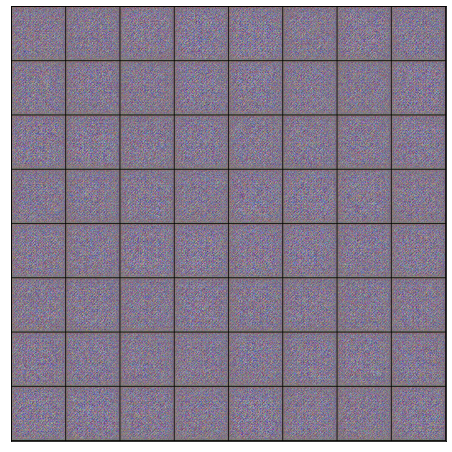

In [ ]:
fake_images = generator(xb.to(device))
print(fake_images.shape)
show_images(fake_images.cpu())

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    #nn.Sigmoid()
  )

In [ ]:
discriminator.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

Image saving untility functions

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Discriminator and generateor training functions

In [ ]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through discriminator
  real_preds = discriminator(real_images)
  real_loss = torch.mean(real_preds)
  
  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent.to(device))

  # Pass fake images through discriminator
  fake_preds = discriminator(fake_images)
  fake_loss = torch.mean(fake_preds)

  # Update discriminator weights
  loss = fake_loss - real_loss
  loss.backward()
  opt_d.step()

  # Parameter(Weight) Clipping for K-Lipshitz constraint
  for p in discriminator.parameters():
    p.data.clamp_(-0.01, 0.01)
  return loss.item()

Step-by-step run to understand the train_discriminator function

In [ ]:
for real_images, _ in train_dl:
  break
print(real_images.shape)

torch.Size([128, 3, 128, 128])


In [ ]:
real_preds = discriminator(real_images.to(device))
print(real_preds.shape, real_preds[0])

torch.Size([128, 1]) tensor([0.3924], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
real_loss = torch.mean(real_preds)
print(real_loss)

tensor(0.4099, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
# Generate latent vector for fake images generation
latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
print(latent.shape)

torch.Size([128, 128, 1, 1])


In [ ]:
fake_images = generator(latent.to(device))
print(fake_images.shape)

torch.Size([128, 3, 128, 128])


In [ ]:
# Pass fake images through discriminator
fake_preds = discriminator(fake_images)
fake_loss = torch.mean(fake_preds)
print(fake_loss)

tensor(0.2891, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
# Parameter(Weight) Clipping for K-Lipshitz constraint
for p in discriminator.parameters():
  p.data.clamp_(-0.01, 0.01)

In [ ]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()
  
  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)
  
  # Try to fool the discriminator
  preds = discriminator(fake_images)
  loss = -torch.mean(preds)
  
  # Update generator weights
  loss.backward()
  opt_g.step()
  
  return loss.item()

# The main training loop

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Losses & scores
losses_g = []
losses_d = []

In [ ]:
lr = 0.0002

In [ ]:
# Create optimizers
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
epochs = 5 #for real training, try 50000
start_idx=1

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
# used to generate saved images

In [ ]:
for epoch in range(epochs):
  if(epoch % 10 ==0):
    print(epoch, end=",")
  for real_images, _ in train_dl:
    # Train discriminator
    loss_d = train_discriminator(real_images.to(device), opt_d)
    # Train generator
    loss_g = train_generator(opt_g)
      
  # Record losses & scores
  losses_g.append(loss_g)
  losses_d.append(loss_d)
  
  if(epoch % 50 ==0):
    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

0,Epoch [1/5], loss_g: 0.3669, loss_d: -0.4831
Saving generated-images-0001.png


In [ ]:
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

In [ ]:
img_array = []
for filename in files:
  img = cv2.imread(filename)
  height, width, layers = img.shape
  size = (width,height)
  img_array.append(img) 
 
out = cv2.VideoWriter('GANTrainingVideo.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

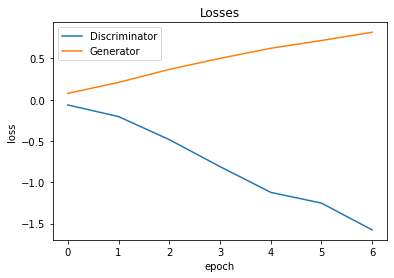

In [ ]:
#fig=plt.figure(figsize=(12, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

#Please refer to 8.1.GAN to copy the code to here to study how the latent vector affect the generated image